In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import dataloader
import preprocessing
import sampling

# Analyze correlation between ERSP and solution latency

In [2]:
ERSP_all, tmp_all, freqs = dataloader.load_data()
ERSP_all, SLs = preprocessing.standardize(ERSP_all, tmp_all)

# Change the dimension of ERSP_all
ERSP_corr = ERSP_all.reshape((ERSP_all.shape[0],-1)).T
print('Shape of ERSP_corr:', ERSP_corr.shape)

# Make SLs the same shape as ERSP_all
SLs_corr = np.tile(SLs, (ERSP_corr.shape[0], 1))
print('Shape of SLs_corr: ', SLs_corr.shape)

Shape of ERSP_all:  (452, 12, 114, 200)
Shape of tmp_all:  (452, 3)
Shape of freqs:  (114,)
Shape of ERSP_corr: (1368, 452)
Shape of SLs_corr:  (1368, 452)


In [26]:
corr_mat = np.corrcoef(ERSP_corr, SLs_corr)
corr_ERSP_SLs = corr_mat[:1368, 1368].reshape((12,-1))
print(corr_ERSP_SLs.shape)

(12, 114)


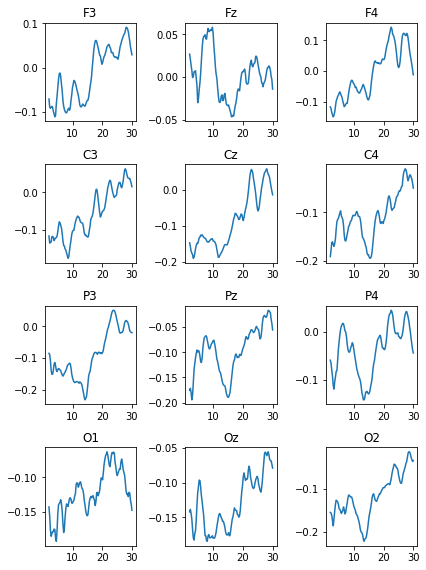

In [44]:
channels = pd.read_csv('Channel_location.csv')['Channel']
fig, axs = plt.subplots(4, 3, figsize=(6, 8))
for i_fig in range(12):
    
    row_fig = i_fig//3
    col_fig = i_fig%3
    
    axs[row_fig, col_fig].plot(freqs, corr_ERSP_SLs[i_fig, :])
    axs[row_fig, col_fig].set_title(channels[i_fig])
    
fig.tight_layout(pad=1.0)
'''
fig.suptitle('Correlation between ERSP and solution latency')
fig.text(0.5, 0.04, 'Frequency (Hz)', ha='center')
fig.text(0.04, 0.5, 'Correlation', va='center', rotation='vertical')
'''
fig.savefig('./results/corr_ERSP_SL.png')